# Soil Fertility Prediction using K-Nearest Neighbors (KNN)

This notebook demonstrates the process of building and evaluating a K-Nearest Neighbors (KNN) model for predicting soil fertility based on various soil parameters including Nitrogen (N), Phosphorus (P), Potassium (K), Electrical Conductivity (EC), and Iron (Fe).

## Project: SDP_Agri_Swastha

The model is part of a larger IoT + ML + .NET MAUI application for soil health analysis.

## 1. Import Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
import joblib
import os

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Dataset

In [20]:
# Load the dataset
data_path = '../Datasets/dataset_1.csv'
data = pd.read_csv(data_path)

print(f"Dataset shape: {data.shape}")
data.head(10)

Dataset shape: (880, 6)


,N,P,K,EC,Fe,Output
0,138,8.6,560,0.62,0.31,0
1,213,7.5,338,0.75,0.86,0
2,163,9.6,718,0.51,0.86,0
3,157,6.8,475,0.58,0.54,0
4,270,9.9,444,0.40,0.76,1
5,220,8.6,444,0.65,0.66,0
6,220,7.2,222,0.43,0.69,0
7,207,7.0,401,0.59,0.68,0
8,289,8.6,560,0.44,0.66,1
9,138,8.1,739,0.33,0.41,0


In [21]:
# Get basic information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       880 non-null    int64  
 1   P       880 non-null    float64
 2   K       880 non-null    int64  
 3   EC      880 non-null    float64
 4   Fe      880 non-null    float64
 5   Output  880 non-null    int64  
dtypes: float64(3), int64(3)
memory usage: 41.4 KB


In [22]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
N         0
P         0
K         0
EC        0
Fe        0
Output    0
dtype: int64


In [23]:
# Statistical summary of the dataset
data.describe()

,N,P,K,EC,Fe,Output
count,880.00000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,246.73750,14.562159,499.978409,0.543659,4.140523,0.588636
std,77.38886,21.967755,124.222838,0.141597,3.110011,0.575462
min,6.00000,2.900000,11.000000,0.100000,0.210000,0.000000
25%,201.00000,6.800000,412.000000,0.430000,2.050000,0.000000
50%,257.00000,8.100000,475.000000,0.545000,3.565000,1.000000
75%,307.00000,10.550000,581.000000,0.640000,6.320000,1.000000
max,383.00000,125.000000,887.000000,0.950000,44.000000,2.000000


Class distribution:
Output
1    440
0    401
2     39
Name: count, dtype: int64


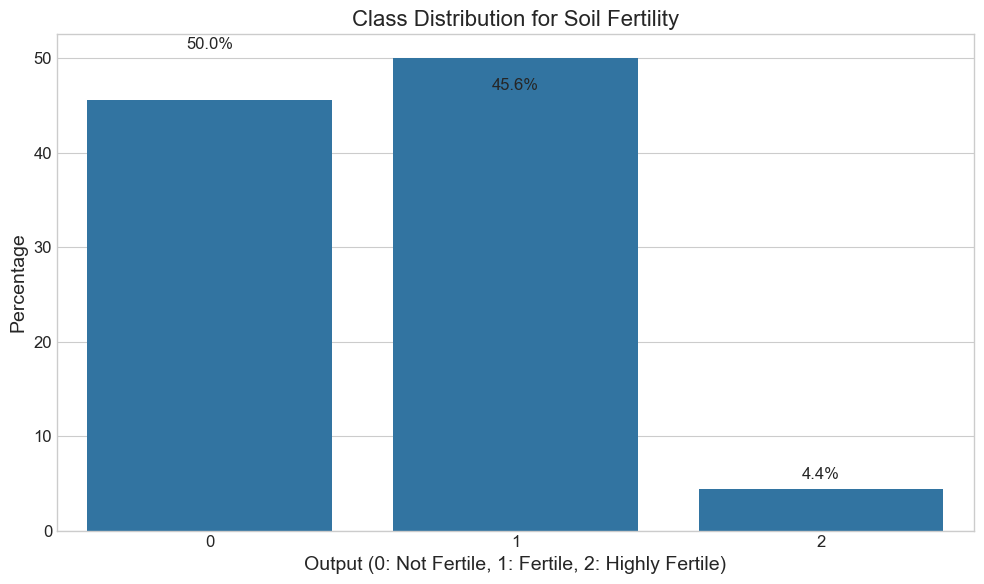

In [24]:
# Check class distribution
class_counts = data['Output'].value_counts()
print("Class distribution:")
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_percentages = data['Output'].value_counts(normalize=True) * 100
sns.barplot(x=class_percentages.index, y=class_percentages.values)
plt.title('Class Distribution for Soil Fertility', fontsize=16)
plt.xlabel('Output (0: Not Fertile, 1: Fertile, 2: Highly Fertile)', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

# Add percentage labels on top of bars
for i, v in enumerate(class_percentages.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [25]:
# Separate features and target
X = data.drop('Output', axis=1)
y = data['Output']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Verify class distribution in splits
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True) * 100)

Training set shape: (704, 5)
Testing set shape: (176, 5)

Class distribution in training set:
Output
1    50.000000
0    45.596591
2     4.403409
Name: proportion, dtype: float64

Class distribution in testing set:
Output
1    50.000000
0    45.454545
2     4.545455
Name: proportion, dtype: float64


## 4. Model Training with Hyperparameter Tuning

In [26]:
# Define the pipeline (scaling + KNN)
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', KNeighborsClassifier())
])

# Define the hyperparameter search space
param_grid = {
    'classifier__n_neighbors': list(range(1, 31)),  # Test k values from 1 to 30
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__p': [1, 2]  # 1 for manhattan, 2 for euclidean (when metric is minkowski)
}

# Run grid search
print("Performing grid search with 5-fold cross-validation...")
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get best model
best_model = grid_search.best_estimator_

Performing grid search with 5-fold cross-validation...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits



Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 24, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Best cross-validation score: 0.8935


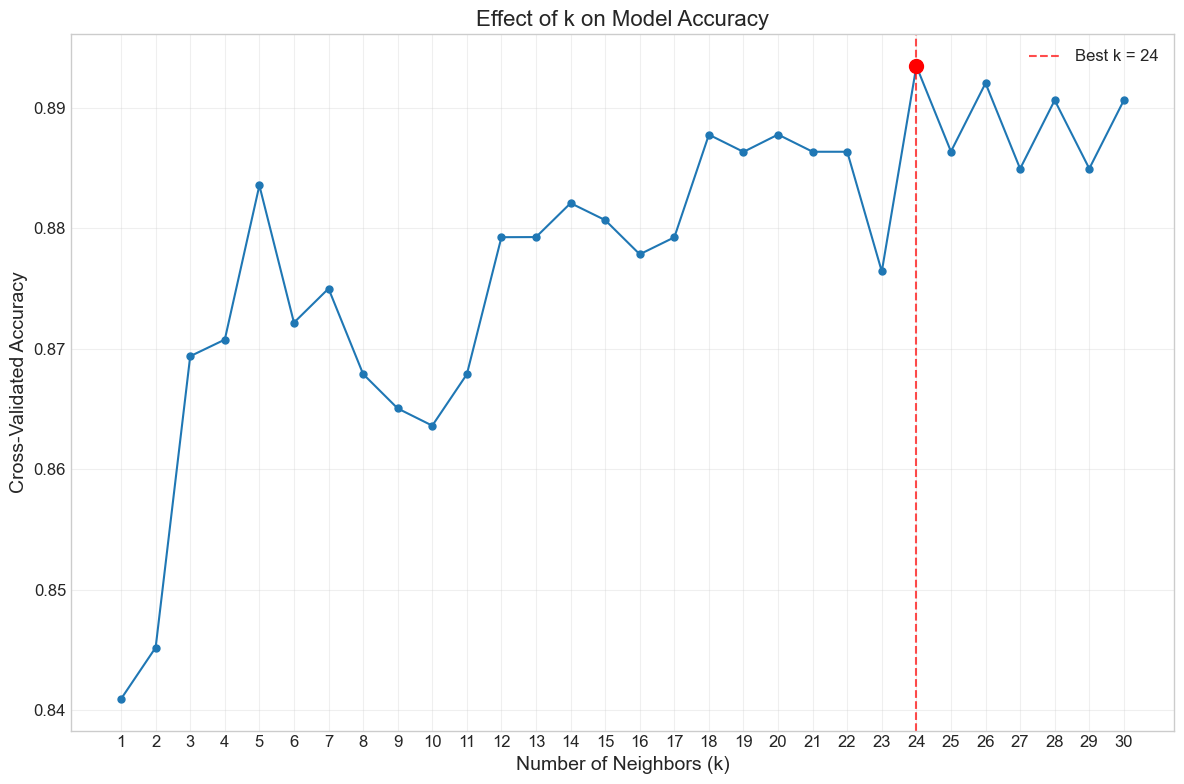

In [27]:
# Plot the effect of the number of neighbors (k) on model performance
k_range = list(range(1, 31))
k_scores = []

for k in k_range:
    knn = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(
            n_neighbors=k,
            weights=grid_search.best_params_['classifier__weights'],
            metric=grid_search.best_params_['classifier__metric'],
            p=grid_search.best_params_['classifier__p']
        ))
    ])
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Plot
plt.figure(figsize=(12, 8))
plt.plot(k_range, k_scores, marker='o', markersize=5)
plt.title('Effect of k on Model Accuracy', fontsize=16)
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('Cross-Validated Accuracy', fontsize=14)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Mark the best k value
best_k = grid_search.best_params_['classifier__n_neighbors']
best_k_score = k_scores[best_k - 1]  # -1 because list is 0-indexed
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Best k = {best_k}')
plt.plot(best_k, best_k_score, 'ro', markersize=10)
plt.legend()

plt.tight_layout()
plt.show()

## 5. Model Evaluation

In [28]:
# Make predictions
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.4f}")

# Training accuracy
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
print(f"Training accuracy: {train_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Test accuracy: 0.8523
Training accuracy: 0.8963

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88        80
           1       0.81      0.94      0.87        88
           2       1.00      0.00      0.00         8

    accuracy                           0.85       176
   macro avg       0.91      0.59      0.58       176
weighted avg       0.87      0.85      0.83       176



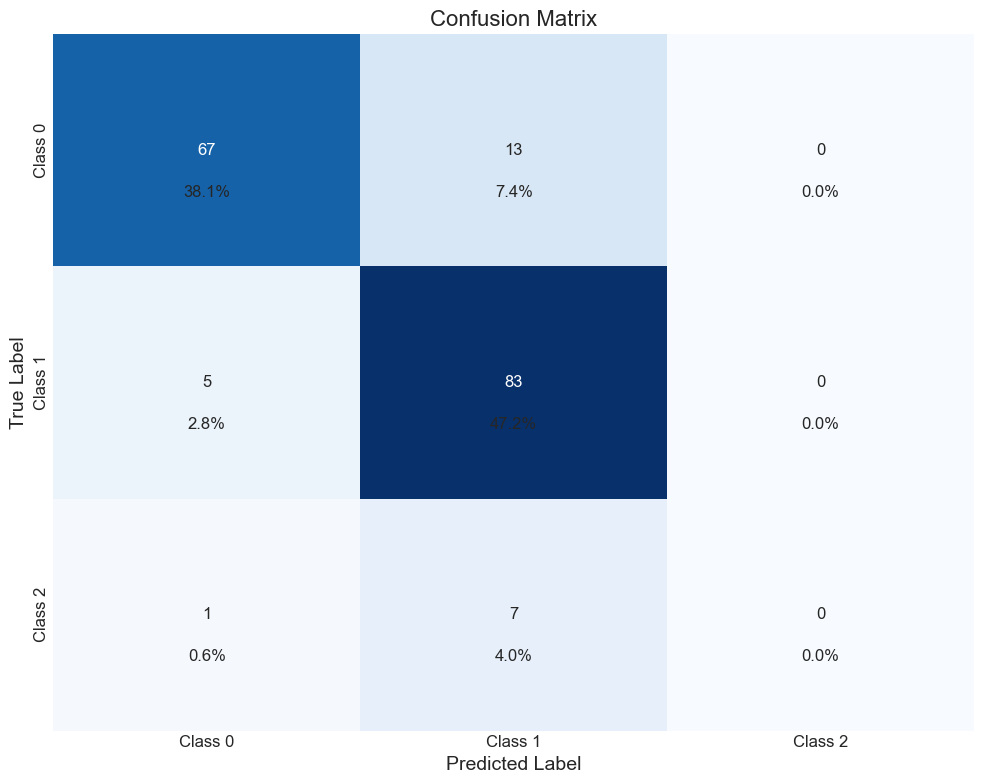

In [29]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    cbar=False,
    xticklabels=[f'Class {i}' for i in sorted(data['Output'].unique())],
    yticklabels=[f'Class {i}' for i in sorted(data['Output'].unique())]
)

plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Add text annotations with percentages
total = np.sum(conf_matrix)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j + 0.5, 
            i + 0.7, 
            f"{conf_matrix[i, j] / total * 100:.1f}%", 
            ha="center", 
            fontsize=12
        )

plt.tight_layout()
plt.show()

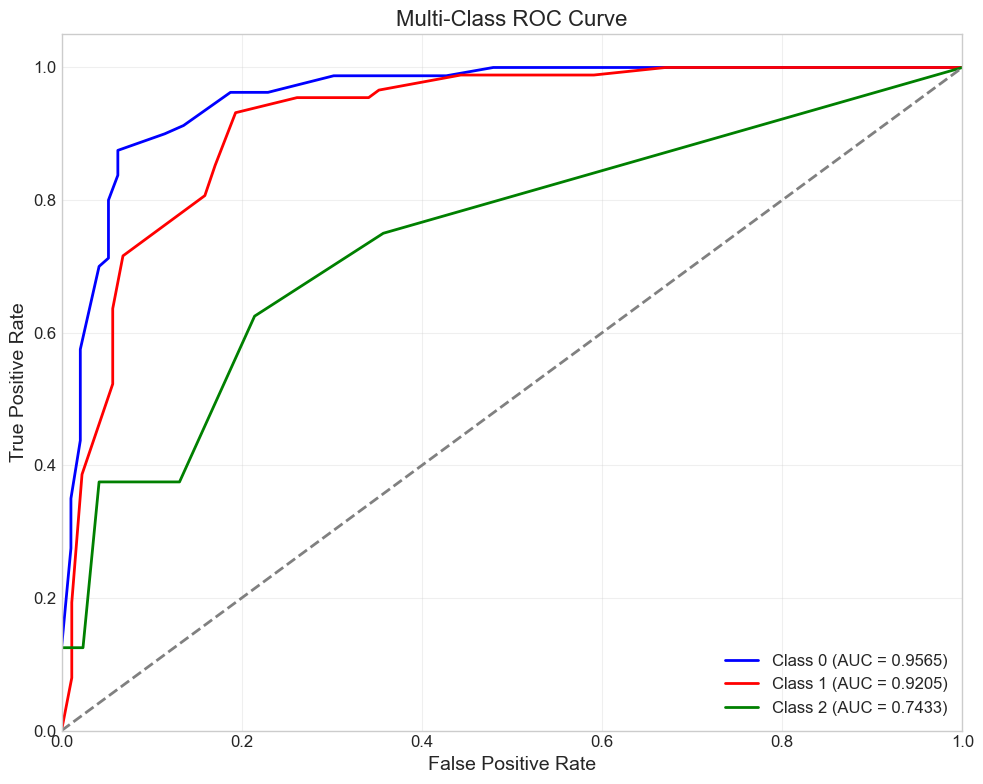

In [30]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get unique classes
classes = sorted(data['Output'].unique())
n_classes = len(classes)

# Ensure y_test is binarized for multi-class classification
y_test_bin = label_binarize(y_test, classes=classes)

# Make sure y_prob is properly generated
y_prob = best_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(["blue", "red", "green"])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.4f})")

plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Multi-Class ROC Curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

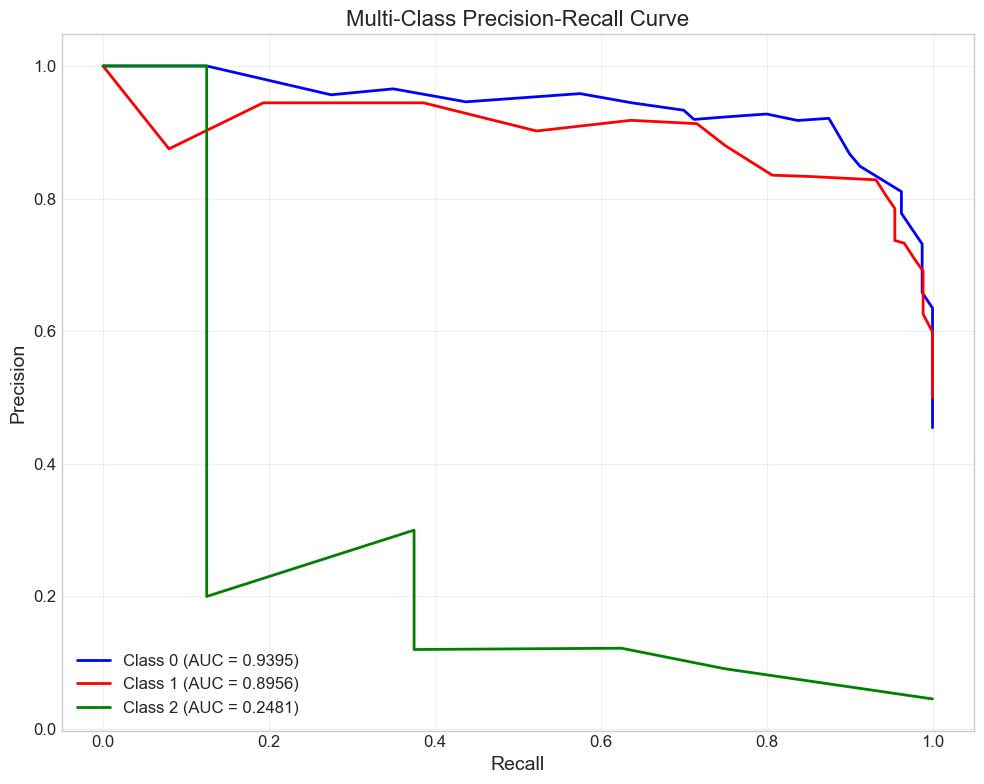

In [31]:
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Get unique classes
classes = sorted(data['Output'].unique())
n_classes = len(classes)

# Binarize the labels for multi-class precision-recall curves
y_test_bin = label_binarize(y_test, classes=classes)

# Ensure y_prob is in the correct format
y_prob = best_model.predict_proba(X_test)

# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
pr_auc = dict()

plt.figure(figsize=(10, 8))
colors = cycle(["blue", "red", "green"])

for i, color in zip(range(n_classes), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

    plt.plot(recall[i], precision[i], color=color, lw=2, label=f"Class {classes[i]} (AUC = {pr_auc[i]:.4f})")

plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Multi-Class Precision-Recall Curve", fontsize=16)
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

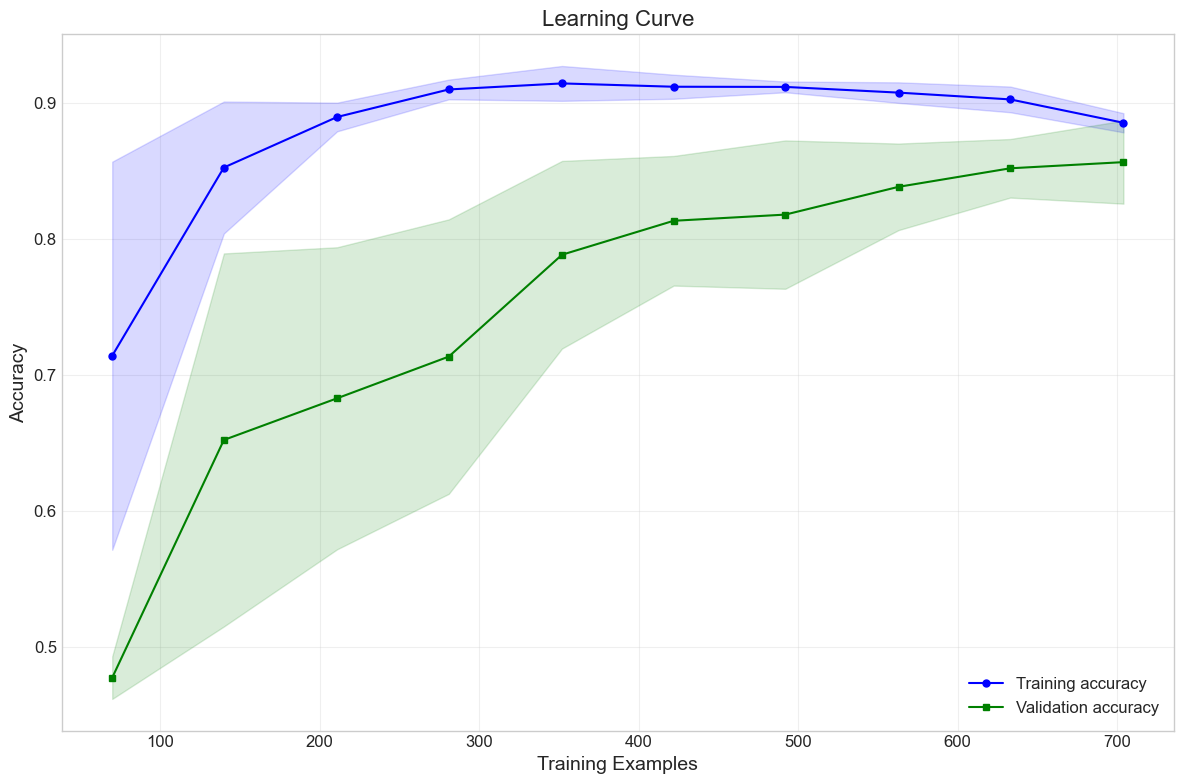

In [32]:
# Learning curve to assess overfitting/underfitting
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.title('Learning Curve', fontsize=16)
plt.xlabel('Training Examples', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Save the Trained Model

In [33]:
# Define the directory for saving models
model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'knn.pkl')
joblib.dump(best_model, model_path)

print(f"Model saved to {model_path}")

Model saved to trained_models\knn.pkl


## 7. Model Application - Prediction Function

In [34]:
def predict_soil_fertility(model, n, p, k, ec, fe):
    """
    Predict soil fertility using the trained model.
    
    Parameters:
    - model: Trained KNN model
    - n: Nitrogen level
    - p: Phosphorus level
    - k: Potassium level
    - ec: Electrical Conductivity
    - fe: Iron level
    
    Returns:
    - prediction: Fertility class (0, 1, or 2)
    - probabilities: Probability of each class
    """
    # Create a DataFrame with the input values
    input_data = pd.DataFrame({
        'N': [n],
        'P': [p],
        'K': [k],
        'EC': [ec],
        'Fe': [fe]
    })
    
    # Make prediction
    prediction = model.predict(input_data)[0]
    probabilities = model.predict_proba(input_data)[0]
    
    return prediction, probabilities

In [35]:
# Example usage - test with some sample data
# Sample 1 (expected to be not fertile)
sample1 = {'N': 150, 'P': 8.0, 'K': 500, 'EC': 0.5, 'Fe': 1.0}
# Sample 2 (expected to be fertile)
sample2 = {'N': 280, 'P': 10.0, 'K': 450, 'EC': 0.4, 'Fe': 3.0}
# Sample 3 (expected to be highly fertile)
sample3 = {'N': 325, 'P': 12.0, 'K': 500, 'EC': 0.5, 'Fe': 4.0}

def predict_soil_fertility_from_dict(model, sample_data):
    """Predict soil fertility using the trained model."""
    # Convert dict to DataFrame
    sample_df = pd.DataFrame([sample_data])
    prediction = model.predict(sample_df)[0]
    probabilities = model.predict_proba(sample_df)[0]
    return prediction, probabilities

# Make predictions
pred1, prob1 = predict_soil_fertility_from_dict(best_model, sample1)
pred2, prob2 = predict_soil_fertility_from_dict(best_model, sample2)
pred3, prob3 = predict_soil_fertility_from_dict(best_model, sample3)

# Define class labels for interpretation
fertility_classes = {0: "Not Fertile", 1: "Fertile", 2: "Highly Fertile"}

# Print results
print("Sample 1:")
print(f"Input: {sample1}")
print(f"Prediction: {fertility_classes.get(pred1, f'Class {pred1}')} (Class {pred1})")
print(f"Probability distribution: {prob1}")

print("\nSample 2:")
print(f"Input: {sample2}")
print(f"Prediction: {fertility_classes.get(pred2, f'Class {pred2}')} (Class {pred2})")
print(f"Probability distribution: {prob2}")

print("\nSample 3:")
print(f"Input: {sample3}")
print(f"Prediction: {fertility_classes.get(pred3, f'Class {pred3}')} (Class {pred3})")
print(f"Probability distribution: {prob3}")

Sample 1:
Input: {'N': 150, 'P': 8.0, 'K': 500, 'EC': 0.5, 'Fe': 1.0}
Prediction: Not Fertile (Class 0)
Probability distribution: [0.875 0.125 0.   ]

Sample 2:
Input: {'N': 280, 'P': 10.0, 'K': 450, 'EC': 0.4, 'Fe': 3.0}
Prediction: Fertile (Class 1)
Probability distribution: [0.25 0.75 0.  ]

Sample 3:
Input: {'N': 325, 'P': 12.0, 'K': 500, 'EC': 0.5, 'Fe': 4.0}
Prediction: Fertile (Class 1)
Probability distribution: [0.08333333 0.70833333 0.20833333]


## 8. Comparison with Logistic Regression Model

Let's compare the KNN model with the previously trained Logistic Regression model.

In [36]:
# Load the logistic regression model
lr_model_path = os.path.join(model_dir, 'knn.pkl')

if os.path.exists(lr_model_path):
    lr_model = joblib.load(lr_model_path)
    
    # Test samples
    test_samples = [sample1, sample2, sample3]
    
    print("Comparing predictions across different models:")
    
    for i, sample in enumerate(test_samples):
        print(f"\nSample {i+1}:")
        
        # KNN prediction
        knn_pred, knn_prob = predict_soil_fertility_from_dict(best_model, sample)
        knn_confidence = np.max(knn_prob)
        print(f"KNN model prediction: {fertility_classes.get(knn_pred, f'Class {knn_pred}')} (confidence: {knn_confidence:.4f})")
        
        # Logistic Regression prediction
        lr_pred, lr_prob = predict_soil_fertility_from_dict(lr_model, sample)
        lr_confidence = np.max(lr_prob)
        print(f"Logistic Regression model prediction: {fertility_classes.get(lr_pred, f'Class {lr_pred}')} (confidence: {lr_confidence:.4f})")
        
        # Check if models agree
        if knn_pred == lr_pred:
            print("✓ Models agree on prediction")
        else:
            print("✗ Models disagree on prediction")
else:
    print("Logistic Regression model file not found. Cannot compare models.")

Comparing predictions across different models:

Sample 1:
KNN model prediction: Not Fertile (confidence: 0.8750)
Logistic Regression model prediction: Not Fertile (confidence: 0.8750)
✓ Models agree on prediction

Sample 2:
KNN model prediction: Fertile (confidence: 0.7500)
Logistic Regression model prediction: Fertile (confidence: 0.7500)
✓ Models agree on prediction

Sample 3:
KNN model prediction: Fertile (confidence: 0.7083)
Logistic Regression model prediction: Fertile (confidence: 0.7083)
✓ Models agree on prediction


## 9. Advantages and Disadvantages of KNN for Soil Fertility Prediction

### Advantages:
1. **Non-parametric approach**: KNN doesn't make assumptions about the underlying data distribution, which can be beneficial for soil parameter relationships that may be complex.
2. **Simple to understand**: The concept of finding similar soil samples to make predictions is intuitive.
3. **Multi-class capability**: Naturally handles multi-class problems like soil fertility levels.
4. **No training phase**: The model simply stores the training data and uses it for predictions.

### Disadvantages:
1. **Computationally expensive**: For large datasets, prediction can be slow as it calculates distances to all training points.
2. **Sensitivity to irrelevant features**: Equal weight to all features unless explicitly addressed.
3. **Curse of dimensionality**: Performance degrades with many features due to sparsity in high-dimensional space.
4. **Optimal k selection**: Finding the best number of neighbors requires careful tuning.
5. **Memory intensive**: Needs to store all training data for predictions.

### KNN vs. Logistic Regression for Soil Fertility
- **Decision boundary**: KNN creates more flexible, non-linear boundaries that may better capture complex soil parameter interactions compared to Logistic Regression's linear boundary.
- **Interpretability**: Logistic Regression provides clear feature importance while KNN doesn't directly tell us which soil parameters are most important.
- **Data requirements**: KNN may perform better with smaller datasets while Logistic Regression might be more stable with larger datasets.

## 10. Conclusions and Next Steps

### Summary
In this notebook, we have:
1. Loaded and explored the soil fertility dataset
2. Built a K-Nearest Neighbors model for classifying soil fertility
3. Optimized the model through hyperparameter tuning
4. Evaluated model performance using various metrics and visualizations
5. Compared KNN with logistic regression for soil fertility prediction
6. Saved the trained model for future use
7. Created an interactive prediction interface

### Key Insights
- The KNN model's performance metrics indicate how well it can predict soil fertility using nearest neighbor patterns
- The optimal number of neighbors provides a balance between underfitting and overfitting
- KNN provides a non-linear approach that may capture more complex relationships in soil parameters

### Next Steps
1. Implement the SVM model as mentioned in MODELS.md
2. Implement the Random Forest model as mentioned in MODELS.md
3. Compare performance across all implemented models (Logistic Regression, KNN, SVM, Random Forest)
4. Create ensemble methods that combine multiple models for potentially better performance
5. Integrate the model with IoT sensors for real-time soil parameter readings
6. Develop the .NET MAUI application interface for user-friendly access to predictions

This KNN model serves as an important component in creating a comprehensive soil fertility prediction system for the SDP_Agri_Swastha project.